From the site: "A dataset (~15M reviews about ~2M books and 465K users) containing comprehensive book reviews from users, aiding in review analysis and sentiment analysis."

Since 15M is very large and I didn't have the capacity to explore the whole dataset, for the purpuse of the EDA I loaded in only 10,000 rows. I spent a lot of time trying to take a random sample but that required passing over large amounts of the dataset and I began to get memory issues. Eventually, I had to opt for an alternative. This is something I need to tackle before beginning more actual project work. Still, I will show later that even the first 10,000 rows give a good idea about the rest of the dataset. 

In [5]:
import gc
gc.collect()

3448

In [6]:
import dask.dataframe as dd

ddf = dd.read_json("goodreads_reviews_dedup.json", lines=True, nrows=10000)
df = ddf.compute()

In [10]:
df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0


In [12]:
!pip install wordcloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   ---------------------------------------  297.0/300.2 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 3.1 MB/s eta 0:00:00


We see in this partition there are no null values. However in the following cell we see there are 383 instances with a 0 star rating. This is due to some issue or error because 0 star ratings are not possible in Goodreads. For this reason, going forward as well we will be dropping all 0 star rating instances. We can consider it to be a kind of null value. It is possible there's null values for other columns, but the only feature we really need for our project is the review_text, and the target which is the rating. From the review_text we will process it to extract more features for our model. 

In [19]:
print(f"Shape of DataFrame: {df.shape}")
print("Null counts:")
df.isnull().sum()

Shape of DataFrame: (10000, 11)
Null counts:


user_id         0
book_id         0
review_id       0
rating          0
review_text     0
date_added      0
date_updated    0
read_at         0
started_at      0
n_votes         0
n_comments      0
dtype: int64

In [39]:
zero_star_count = df[df['rating'] == 0].shape[0]
print(f"Number of reviews with 0 stars: {zero_star_count}")
df = df[df['rating'] != 0]
df.reset_index(drop=True, inplace=True)

Number of reviews with 0 stars: 383


In [41]:
print(f"Shape of DataFrame: {df.shape}") #new shape after dropping some values

Shape of DataFrame: (9617, 13)


In [40]:
df.dtypes #just checking the datatypes

user_id           object
book_id            int64
review_id         object
rating             int64
review_text       object
date_added        object
date_updated      object
read_at           object
started_at        object
n_votes            int64
n_comments         int64
review_length      int64
sentiment        float64
dtype: object

In [42]:
len(df['user_id'].unique()) #we have 243 unique users in this partition

243

In [43]:
len(df['book_id'].unique()) #8437 unique books in this partition

8437

Most users have left about 20 reviews, with some very small groups at 1000 reviews. 

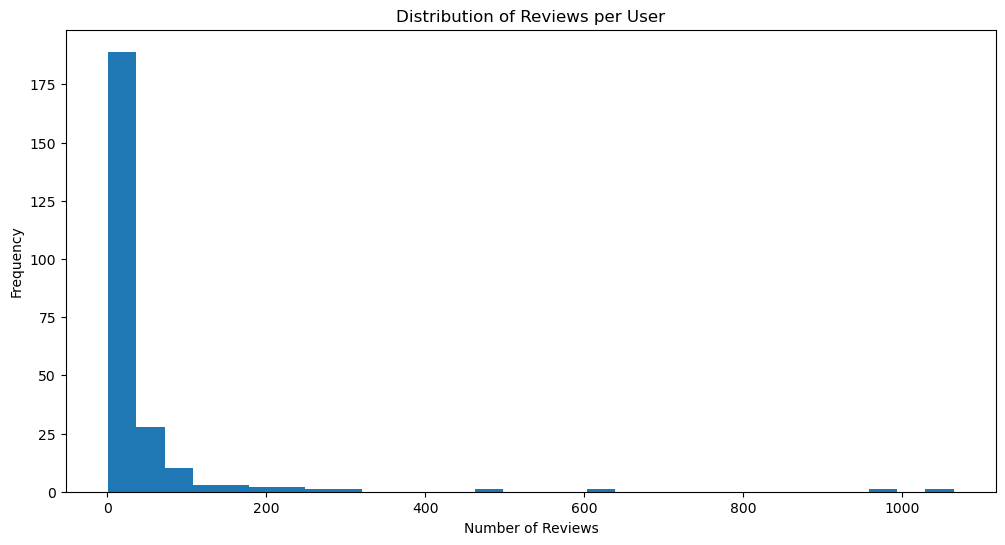

In [44]:
reviews_per_user = df['user_id'].value_counts()
reviews_per_user.plot(kind='hist', bins=30, figsize=(12, 6))
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

Almost all books in this partition have a very small number of reviews in this dataset. However, I don't think this will be an issue. It might even be a positive, since if most reviews are for different books, it will learn many new and different features hopefully to predict the ratings and won't learn book-specific things. However, with some users having 1000 reviews, there is a very small chance the model may learn some user-specific things. Still, it shouldn't be an issue since we are predicting numerical ratings based on these text reviews, and nothing else. 

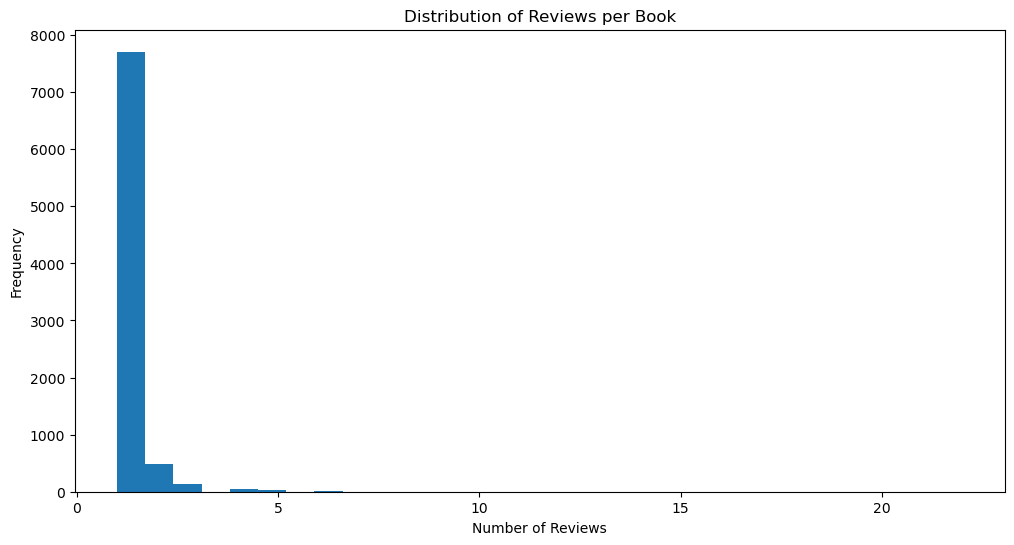

In [45]:
reviews_per_book = df['book_id'].value_counts()
reviews_per_book.plot(kind='hist', bins=30, figsize=(12, 6))
plt.title('Distribution of Reviews per Book')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

However, we do run into more of an issue here as the data set is very imbalanced towards moderate ratings. Most ratings are 4, otherwise 3 or 5. We have to take care that the model won't simply start predicting the majority class. One possible way to combat this could be increasing our sample of lower ratings in our training data from the overall dataset to create balance. Since there are 15M reviews total, I think it is possible to train a well performing model using only a sample of that data. 

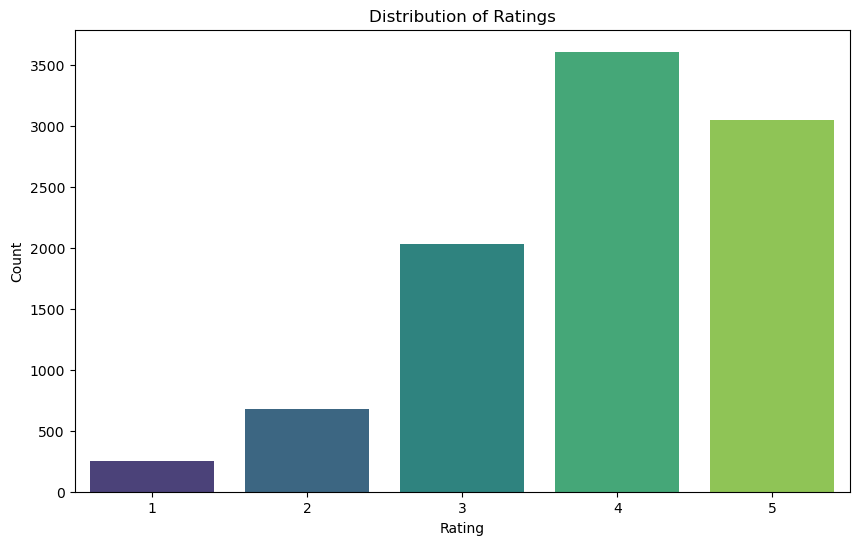

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

We see in the word cloud some of the most common words don't really give away any specific sentiment such as "book", "read", and "story". However there are more polar words like "love" which are still quite large. Overall, the most used words seem to provide some type of insights the model could draw from. 

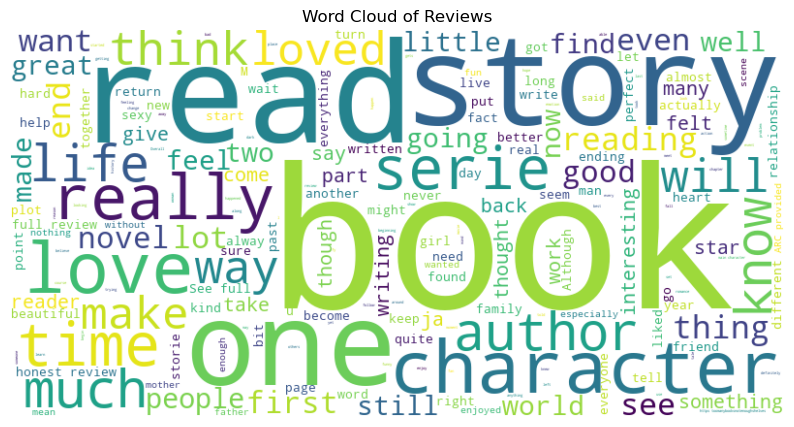

In [47]:
text = " ".join(review for review in df.review_text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

I was curious if review length had anything to do with rating, maybe someone who gave a book a 5 star would be more likely to leave a long review explaining why they loved it and someone who gave a 1 star rating would just say "I hated it". 

First we look at the distribtuion of review lengths, and almost all reviews are on the shorter end, so there's a very heavy left skew. 

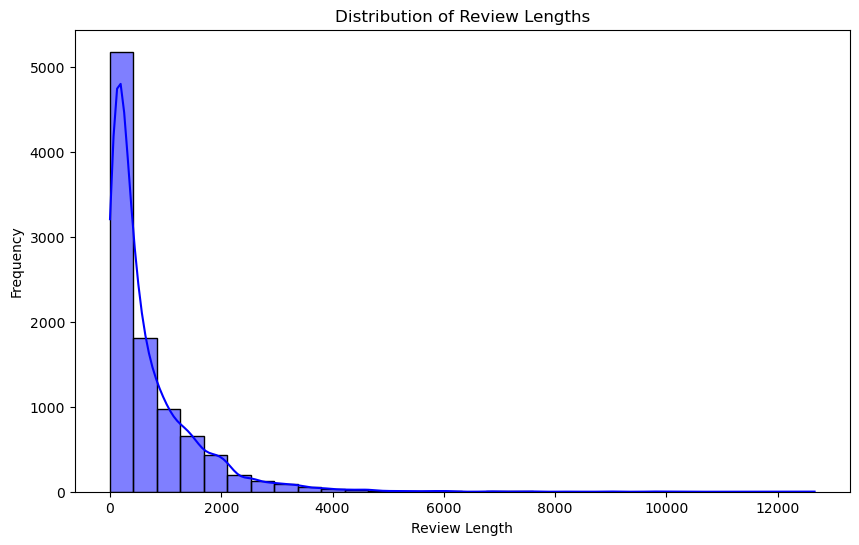

In [48]:
df['review_length'] = df['review_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

However in this plot we see that my intuition may not have been correct, since the correlation is only 0.10. It's possible the different spreads we see may just be due to there being more 5 star and 4 star ratings than lower ratings. Still, despite the correlation, I feel like the plot lends some credence to the theory just visually. There's some real outliers in the 2 rating, maybe people who had really conflicting opinions to go through, but overall this doesn't seem like a hugely predictive feature. 

Correlation between review length and rating: 0.10


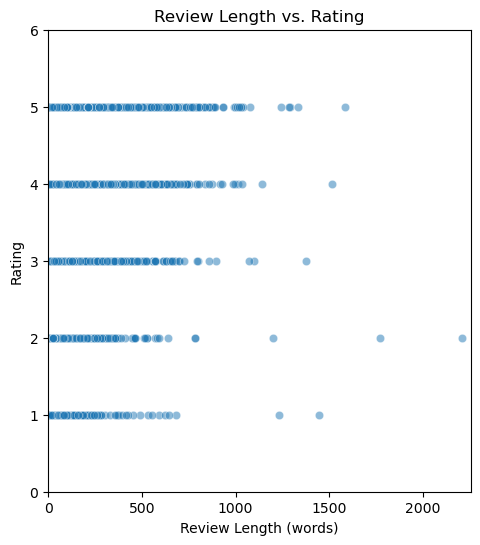

In [49]:
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='review_length', y='rating', alpha=0.5)
plt.title('Review Length vs. Rating')
plt.xlabel('Review Length (words)')
plt.ylabel('Rating')
plt.xlim(0,df['review_length'].max()+50)  
plt.ylim(0,df['rating'].max()+1)  

correlation = df[['review_length', 'rating']].corr().iloc[0, 1]
print(f"Correlation between review length and rating: {correlation:.2f}")

In [50]:
!pip install textblob
from textblob import TextBlob

The obvious feature to then consider is the sentiment and the polarity of the reviews. In the actual project I'm still not sure what exact method we will use for the sentiment portion, if that will be a separate feature or we will just let a complex model try to find its own pattern. Still, for the purpose of the exploration, I  used TextBlob to get a quick sentiment polarity and compare it to the ratings. The correlation is higher at 0.31, which is not super high, but points to this being a stronger indicator.

Furthermore, in the plot we see a larger right skew as the rating increases, as we might expect. 

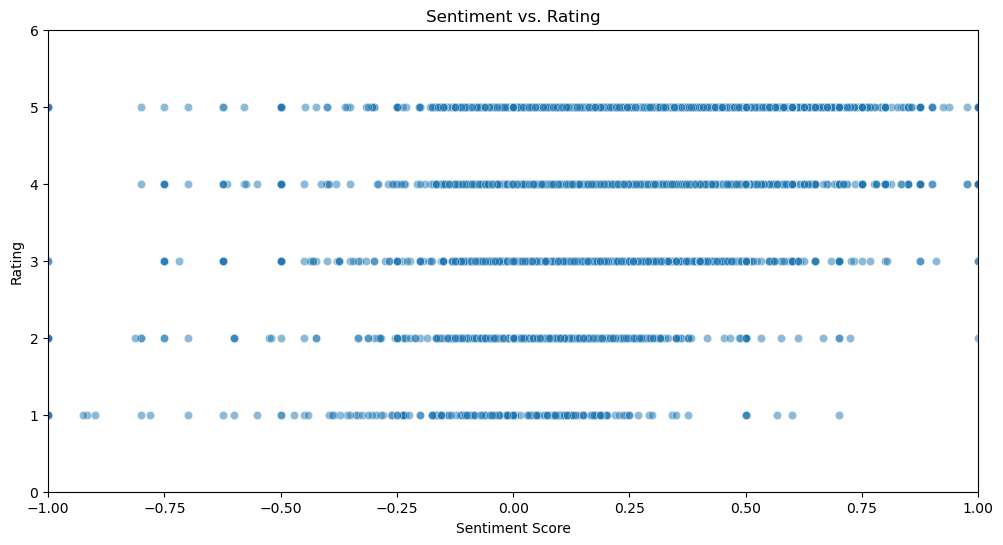

Correlation between sentiment and rating: 0.31


In [53]:
df['sentiment'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='sentiment', y='rating', alpha=0.5)
plt.title('Sentiment vs. Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.xlim(-1, 1)  
plt.ylim(0, df['rating'].max() + 1)  
plt.show()

correlation = df[['sentiment', 'rating']].corr().iloc[0, 1]
print(f"Correlation between sentiment and rating: {correlation:.2f}")

Out of curious I wanted to see what the more positive sentiments with low ratings looked like. In the first instance the "loved" is about the movie, not the book, but obviously Textblob doesn't know we are concerned with their opinions on the book. The third one is surprisingly high to me, but these are not particularly useful observations. I think a human reading it would put the sentiment polarity much lower. 

In [52]:
zero_rating_high_polarity = df[(df['rating'] == 1) & (df['sentiment'] > 0.5)]
zero_rating_high_polarity[['review_text', 'sentiment']].head(10)

,review_text,sentiment
2325,"In a Twilight-Zone twist, I loved the movie and didn't care for the book.",0.700000
3356,I really hope that Aelin meet some of the characters in this book in the latest installment :D,0.566667
7620,Not my kind of book.,0.600000
